# Proyecto: Evaluación de Modelos de Pronóstico de Precios de Energía Eléctrica y Tendencias

In [1]:
import pickle
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['font.size'] = 16
matplotlib.rcParams['figure.figsize'] = (9, 9)
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import (r2_score, mean_squared_error, accuracy_score, precision_score, recall_score,
                             f1_score, roc_auc_score, roc_curve, precision_recall_curve, make_scorer,
                             confusion_matrix, multilabel_confusion_matrix, ConfusionMatrixDisplay)

from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor,ExtraTreesRegressor,ExtraTreesClassifier
from xgboost import XGBClassifier, XGBRegressor
import shap
from sklearn.pipeline import Pipeline

from sklearn.base import BaseEstimator

class SelectorModelos(BaseEstimator):
    def __init__(self,model):
        """
            A Custom BaseEstimator
        """ 
        self.model=model
        self.estimator = self.model
    def fit(self, X, y=None, **kwargs):
        self.estimator.fit(X, y)
        return self

    def predict(self, X, y=None):
        return self.estimator.predict(X)

    def predict_proba(self, X):
        return self.estimator.predict_proba(X)

    def score(self, X, y):
        return self.estimator.score(X, y)

### Lectura de base de datos

In [2]:
# lectura de variables para pronostico de PML y OVEMEM
rawdata = pd.read_excel('data\input_vars.xlsx')
print(rawdata.dtypes,rawdata.isnull().sum())

Fecha      datetime64[ns]
Mes                 int64
Dia                 int64
Diasem              int64
Hora                int64
Fest                int64
MDA               float64
MTR               float64
Spread            float64
Bin                 int64
MW                float64
SIN               float64
FC                  int64
MRO               float64
TEM                 int64
EO                float64
FV                float64
RES               float64
MDA2              float64
MDA3              float64
MDA4              float64
MW2               float64
MW3               float64
MW4               float64
EO1               float64
FV1               float64
HSC1              float64
SIN2              float64
Spread4           float64
FC1                 int64
Bin3                int64
Binh3               int64
Bin7                int64
Bin14               int64
dtype: object Fecha      0
Mes        0
Dia        0
Diasem     0
Hora       0
Fest       0
MDA        0
MTR        

In [3]:
df_datestr=rawdata[['Fecha','Hora']]
df_datetime=pd.DataFrame({'Fecha': rawdata.Fecha
                         +pd.to_timedelta(rawdata.Hora,unit='h')})

df_pml=rawdata.copy()
df_pml['Fecha']=df_datetime['Fecha'].dt.strftime('%d/%m/%Y %H')
df_pml.set_index('Fecha',inplace=True)

### Rango de fechas para inputs de modelo

In [4]:
date_rng=['01/07/2021 01','01/01/2023 00']
hist_data=df_pml[date_rng[0]:date_rng[1]]

### Datos de validación

In [5]:
val_data=df_pml['01/01/2023 01':]
val_data

,Mes,Dia,Diasem,Hora,Fest,MDA,MTR,Spread,Bin,MW,...,EO1,FV1,HSC1,SIN2,Spread4,FC1,Bin3,Binh3,Bin7,Bin14
Fecha,,,,,,,,,,,,,,,,,,,,,
01/01/2023 01,1,1,1,1,1,316.96,347.97,31.01,1,467.638,...,856.207,0.000,2.200,27733.012731,-22.06,0,1,1,0,0
01/01/2023 02,1,1,1,2,1,122.18,329.72,207.54,1,458.698,...,831.698,0.000,2.200,27733.012731,-95.82,0,1,1,0,1
01/01/2023 03,1,1,1,3,1,303.64,328.55,24.91,1,448.494,...,812.844,0.000,2.200,27733.012731,-97.08,0,1,1,1,0
01/01/2023 04,1,1,1,4,1,111.55,292.46,180.91,1,442.856,...,782.224,0.000,2.200,27733.012731,-57.44,0,0,1,1,0
01/01/2023 05,1,1,1,5,1,63.46,292.40,228.94,1,429.287,...,724.389,0.000,2.200,27733.012731,-82.93,0,0,1,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14/01/2023 20,1,14,7,20,0,568.65,0.00,-568.65,0,680.269,...,3019.987,0.293,3.225,29630.229167,-782.70,1,0,0,0,1
14/01/2023 21,1,14,7,21,0,515.84,0.00,-515.84,0,675.218,...,3190.064,0.000,3.225,29630.229167,-652.36,0,0,0,0,1
14/01/2023 22,1,14,7,22,0,511.05,0.00,-511.05,0,661.245,...,3212.694,0.000,3.225,29630.229167,-175.33,0,0,0,0,1


### Visualización de features

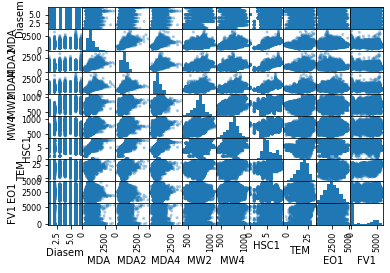

In [6]:
pml_data=hist_data[['Diasem','MDA','MDA2','MDA4','MW2','MW4','HSC1','TEM','EO1','FV1']]
pd.plotting.scatter_matrix(pml_data,alpha=0.4);

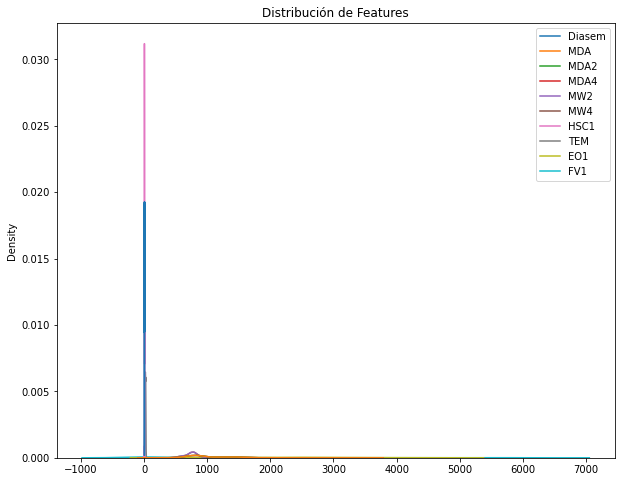

In [7]:
fig,ax=plt.subplots(figsize=(10, 8))
ax.set_title('Distribución de Features')
sns.kdeplot(pml_data);

### Conjuntos  de entrenamiento y prueba

In [8]:
X,y=pml_data.drop('MDA',axis=1),pml_data['MDA']
cols=X.columns.tolist()

In [9]:
X_train,X_test,y_train,y_test=train_test_split(X,y,shuffle=False)
X_test

,Diasem,MDA2,MDA4,MW2,MW4,HSC1,TEM,EO1,FV1
Fecha,,,,,,,,,
16/08/2022 19,3,1410.32,1350.50,814.461,854.953,8.3,23,2057.188,3169.998
16/08/2022 20,3,1392.82,1361.55,801.229,837.370,8.3,22,1922.460,2346.588
16/08/2022 21,3,1453.46,1536.82,812.478,811.098,8.3,21,1812.593,1142.785
16/08/2022 22,3,1638.74,1597.40,814.117,823.156,8.3,21,1708.484,243.471
16/08/2022 23,3,1441.59,1555.29,819.574,836.620,8.3,21,1620.532,5.651
...,...,...,...,...,...,...,...,...,...
31/12/2022 20,7,592.72,910.03,672.048,719.535,2.2,17,1236.534,0.023
31/12/2022 21,7,600.16,887.30,668.302,700.944,2.2,15,1204.235,0.000
31/12/2022 22,7,567.55,871.94,659.312,677.578,2.2,14,1138.072,0.000


### Preprocesamiento de datos

In [10]:
ss = StandardScaler()
ss.fit(X_train)
X_train_scaled = pd.DataFrame(ss.transform(X_train),columns=cols,index=X_train.index)
X_test_scaled = pd.DataFrame(ss.transform(X_test),columns=cols,index=X_test.index)

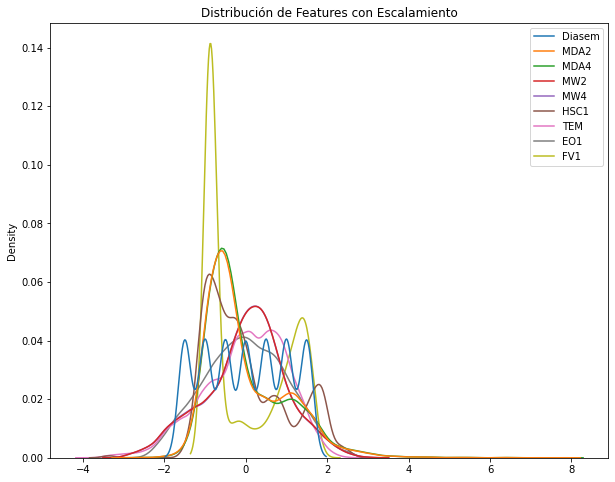

In [11]:
fig,ax=plt.subplots(figsize=(10, 8))
ax.set_title('Distribución de Features con Escalamiento')
sns.kdeplot(X_train_scaled);

### Modelos de Regresión

In [12]:
date_val=['12/01/2023 01','13/01/2023 00']
X_val=val_data.loc[date_val[0]:date_val[1],cols];y_val=val_data.loc[date_val[0]:date_val[1],'MDA']

#### Modelos utilizados y grid de parámetros

In [ ]:
#model_list=[Ridge(),Lasso(),RandomForestRegressor(),ExtraTreesRegressor()]

#params=[{'selector__model__alpha':np.logspace(-2,4,100)},
#        {'selector__model__alpha':np.logspace(-2,4,100)},
#        {'selector__model__n_estimators': np.arange(50,1050,100),
#         'selector__model__max_depth': list(range(1,7)),
#         'selector__model__random_state':[16]},
#        {'selector__model__n_estimators': np.arange(50,1050,100),
#         'selector__model__max_depth': list(range(1,7)),
#         'selector__model__random_state':[16]}
#       ]

In [13]:
model_list=[Ridge(),Lasso(),ElasticNet(),
            RandomForestRegressor(),ExtraTreesRegressor(),
            XGBRegressor()]

params=[{'selector__model__alpha':np.logspace(-2,4,100)},
        {'selector__model__alpha':np.logspace(-2,4,100)},
        {'selector__model__alpha':np.logspace(-2,4,100),
         'selector__model__l1_ratio': list(np.linspace(0.01,0.99,25))},
        {'selector__model__n_estimators': np.arange(50,1050,100),
         'selector__model__max_depth': list(range(1,7)),
         'selector__model__random_state':[16]},
        {'selector__model__n_estimators': np.arange(50,1050,100),
         'selector__model__max_depth': list(range(1,7)),
         'selector__model__random_state':[16]},
        {'selector__model__n_estimators': np.arange(50,1050,100),
         'selector__model__max_depth': list(range(1,7))}
       ]

In [14]:
res=[]
for k,mdl in enumerate(model_list):
    pipe_tst=Pipeline(steps=[
        ('preprocessor',StandardScaler()),
        ('selector',SelectorModelos(mdl))
    ])
    gs=GridSearchCV(pipe_tst,params[k])
    gs.fit(X_train,y_train)
    res.append([gs.best_estimator_,
                gs.best_params_,
                gs.best_score_,
                gs.score(X_test,y_test)])

In [22]:
final_res=pd.DataFrame(res,columns=['Model','Params','TrainR2','TestR2'])

In [26]:
best_model=final_res['Model'][final_res['TestR2']==max(final_res['TestR2'])].values[0]
y_hat=best_model.predict(X_val)
ape=abs(y_val.values-y_hat)/y_val.values
mape=ape.mean()
print(best_model.score(X_val,y_val),mape)

0.6008602646906314 0.11934481868890445
